# Customer Dataset — Exploratory Data Analysis

**The golden rule of EDA:** Every chart answers a question. Never plot something just because the column exists.

This notebook follows a 5-question framework:
1. Who are our customers? *(demographics)*
2. How do they behave? *(purchase patterns)*
3. What drives spending? *(relationships)*
4. Which customers are at risk? *(satisfaction + support)*
5. Are there natural customer groups? *(RFM + segmentation bridge)*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Consistent style for the whole notebook
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

df = pd.read_csv('data/customer_dataset_cleaned.csv',
                 parse_dates=['join_date', 'last_purchase_date'])

print(f'Shape: {df.shape}')
df.head(3)

Shape: (946, 21)


,customer_id,full_name,email,phone,age,gender,city,region,annual_income,join_date,...,total_purchases,total_spend,avg_order_value,discount_usage_pct,support_tickets_raised,email_open_rate,preferred_category,satisfaction_score,loyalty_tier,days_active
0,CUST00927,Michael Anderson,True,+1-359-742-8546,36.0,1,Chicago,Midwest,56700.0,2022-03-15,...,19,1442.24,75.907368,0.47,3,0.64,Food & Grocery,3.6,Bronze,880.0
1,CUST00683,Stephanie Lewis,True,+1-406-209-8952,32.0,1,Los Angeles,West,74300.0,2022-02-17,...,20,2010.19,100.509500,0.73,3,0.42,Clothing,3.1,Bronze,951.0
2,CUST00366,Stephanie Young,True,+1-237-664-5269,23.0,1,New York,Northeast,49100.0,2021-09-18,...,16,1977.22,123.576250,0.77,3,0.51,Toys,3.8,Bronze,1057.0


---
## Section 1 — Who are our customers?

Before looking at behaviour, understand *who* is in this dataset.
Key questions:
- What is the age distribution? Is it skewed toward younger or older customers?
- How is income spread? Are most customers mid-income or is there a wide range?
- Where are customers located — which regions dominate?

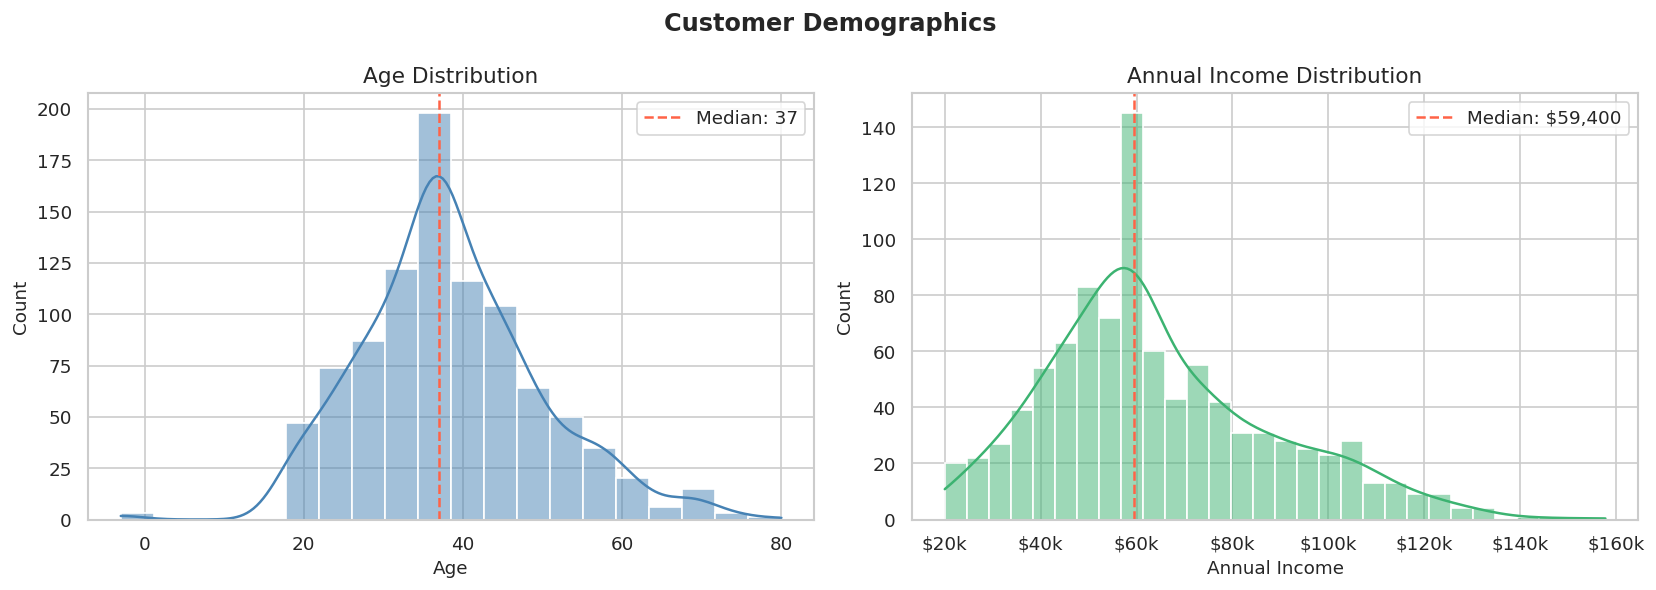

In [2]:
# --- Q: What does the age distribution look like? ---
# Why histogram + KDE: shows shape (skew, peaks) better than a boxplot alone.
# Why we add a median line: gives a single reference point without hiding the shape.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Customer Demographics', fontweight='bold')

# Age distribution
ax = axes[0]
sns.histplot(df['age'].dropna(), bins=20, kde=True, ax=ax, color='steelblue')
ax.axvline(df['age'].median(), color='tomato', linestyle='--', linewidth=1.5,
           label=f'Median: {df["age"].median():.0f}')
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

# Annual income distribution
# Why log scale: income is almost always right-skewed — log makes the shape readable
ax = axes[1]
sns.histplot(df['annual_income'].dropna(), bins=30, kde=True, ax=ax, color='mediumseagreen')
ax.axvline(df['annual_income'].median(), color='tomato', linestyle='--', linewidth=1.5,
           label=f'Median: ${df["annual_income"].median():,.0f}')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.set_title('Annual Income Distribution')
ax.set_xlabel('Annual Income')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation — write this yourself after looking at the chart.**  
*(Template: "The age distribution is [left/right/roughly normally] skewed, with most customers aged between X and Y. The median age is Z. This suggests our core customer base is [young adults / middle-aged / older].")*

*"The age distribution is roughly normally skewed, with most customers aged between 20 and 60. The median age is 36. This suggests our core customer base are middle-aged."*

> **Interview tip:** Always comment on skew, the median vs mean gap, and what it means for the business.

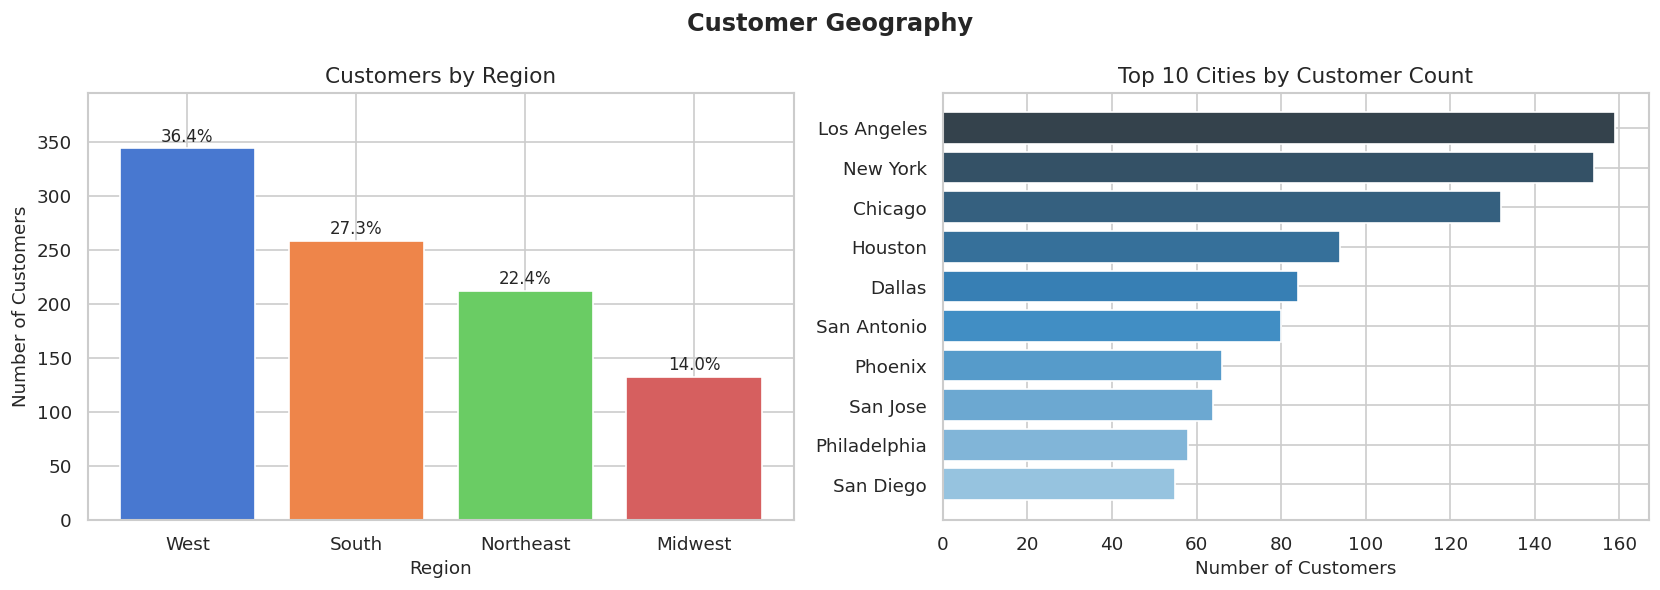

In [3]:
# --- Q: Which regions have the most customers, and are they equal? ---
# Why bar chart (not pie): easy to compare heights; pie slices are hard to judge accurately
# Why we add % labels: raw counts are less meaningful than proportion

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Customer Geography', fontweight='bold')

# Region breakdown
region_counts = df['region'].value_counts()
region_pct = region_counts / region_counts.sum() * 100

ax = axes[0]
bars = ax.bar(region_counts.index, region_counts.values, color=sns.color_palette('muted', len(region_counts)))
for bar, pct in zip(bars, region_pct):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_title('Customers by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Number of Customers')
ax.set_ylim(0, region_counts.max() * 1.15)

# Top 10 cities
# Why top 10 only: showing all cities creates clutter with no extra insight
city_counts = df['city'].str.strip().value_counts().head(10)
ax = axes[1]
ax.barh(city_counts.index[::-1], city_counts.values[::-1],
        color=sns.color_palette('Blues_d', len(city_counts)))
ax.set_title('Top 10 Cities by Customer Count')
ax.set_xlabel('Number of Customers')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("The [X] region accounts for the largest share of customers at Y%. The top city is Z. This matters because geographic concentration affects marketing spend allocation.")*

*("The West region accounts for the largest share of customers at 36.4%. The top city is Los Angeles. This matters because geographic concentration affects marketing spend allocation.")*

---
## Section 2 — How do customers behave?

Now look at purchase behaviour:
- Is spending evenly distributed or do a few customers drive most revenue?
- Do loyal customers (Platinum/Gold) actually spend more?
- Which product categories generate the most revenue?

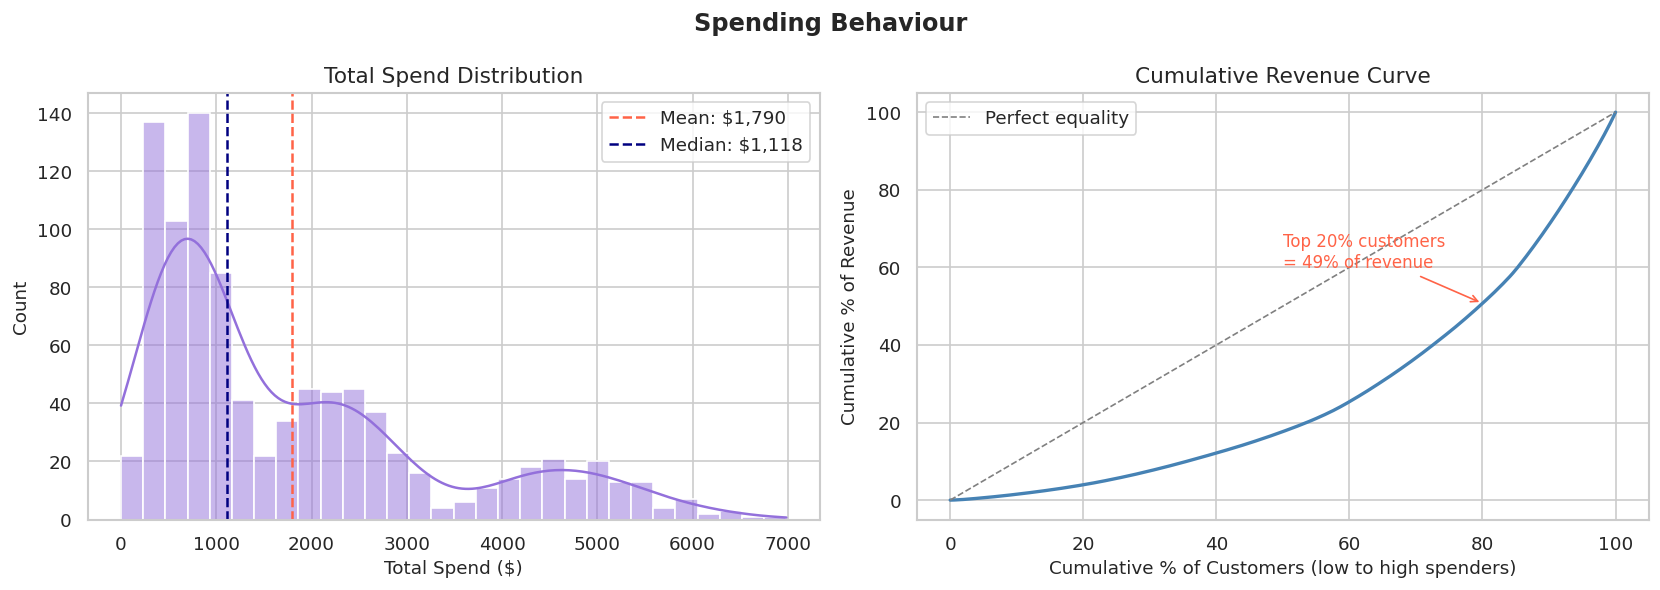

In [4]:
# --- Q: Is spending concentrated in a few customers, or spread evenly? ---
# This is the Pareto / 80-20 question — critical for business strategy.
# How to show it: sort spend descending, compute cumulative %, plot as a line.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Spending Behaviour', fontweight='bold')

# Total spend distribution — note the right skew
ax = axes[0]
sns.histplot(df['total_spend'].dropna(), bins=30, kde=True, ax=ax, color='mediumpurple')
ax.axvline(df['total_spend'].mean(), color='tomato', linestyle='--', linewidth=1.5,
           label=f'Mean: ${df["total_spend"].mean():,.0f}')
ax.axvline(df['total_spend'].median(), color='navy', linestyle='--', linewidth=1.5,
           label=f'Median: ${df["total_spend"].median():,.0f}')
ax.set_title('Total Spend Distribution')
ax.set_xlabel('Total Spend ($)')
ax.legend()
# Key insight: if mean >> median, the distribution is right-skewed
# meaning a small number of high-spenders pull the average up

# Cumulative revenue curve (Lorenz-style)
# Why: shows whether top 20% of customers drive 80% of revenue
ax = axes[1]
sorted_spend = df['total_spend'].dropna().sort_values()
cumulative_pct_customers = np.linspace(0, 100, len(sorted_spend))
cumulative_pct_revenue = sorted_spend.cumsum() / sorted_spend.sum() * 100

ax.plot(cumulative_pct_customers, cumulative_pct_revenue, color='steelblue', linewidth=2)
ax.plot([0, 100], [0, 100], color='grey', linestyle='--', linewidth=1, label='Perfect equality')

# Mark the 80th percentile of customers
idx_80 = int(0.80 * len(sorted_spend))
rev_at_80 = cumulative_pct_revenue.iloc[idx_80]
ax.annotate(f'Top 20% customers\n= {100-rev_at_80:.0f}% of revenue',
            xy=(80, rev_at_80), xytext=(50, 60),
            arrowprops=dict(arrowstyle='->', color='tomato'),
            fontsize=10, color='tomato')

ax.set_title('Cumulative Revenue Curve')
ax.set_xlabel('Cumulative % of Customers (low to high spenders)')
ax.set_ylabel('Cumulative % of Revenue')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("The mean spend of $X is significantly higher than the median of $Y, confirming right skew — a small number of high-value customers inflate the average. The cumulative revenue curve shows the top 20% of customers account for roughly Z% of revenue — [close to / well above] the Pareto 80-20 rule.")*


*("The mean spend of $1,790 is significantly higher than the median of $1,118, confirming right skew — a small number of high-value customers inflate the average. The cumulative revenue curve shows the top 20% of customers account for roughly 49% of revenue — close to the Pareto 80-20 rule.")*


> **Interview tip:** The mean vs median gap is one of the most common EDA observations interviewers ask you to explain. Always mention it for skewed distributions.

/tmp/ipykernel_16029/1838904222.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='loyalty_tier', y='total_spend',


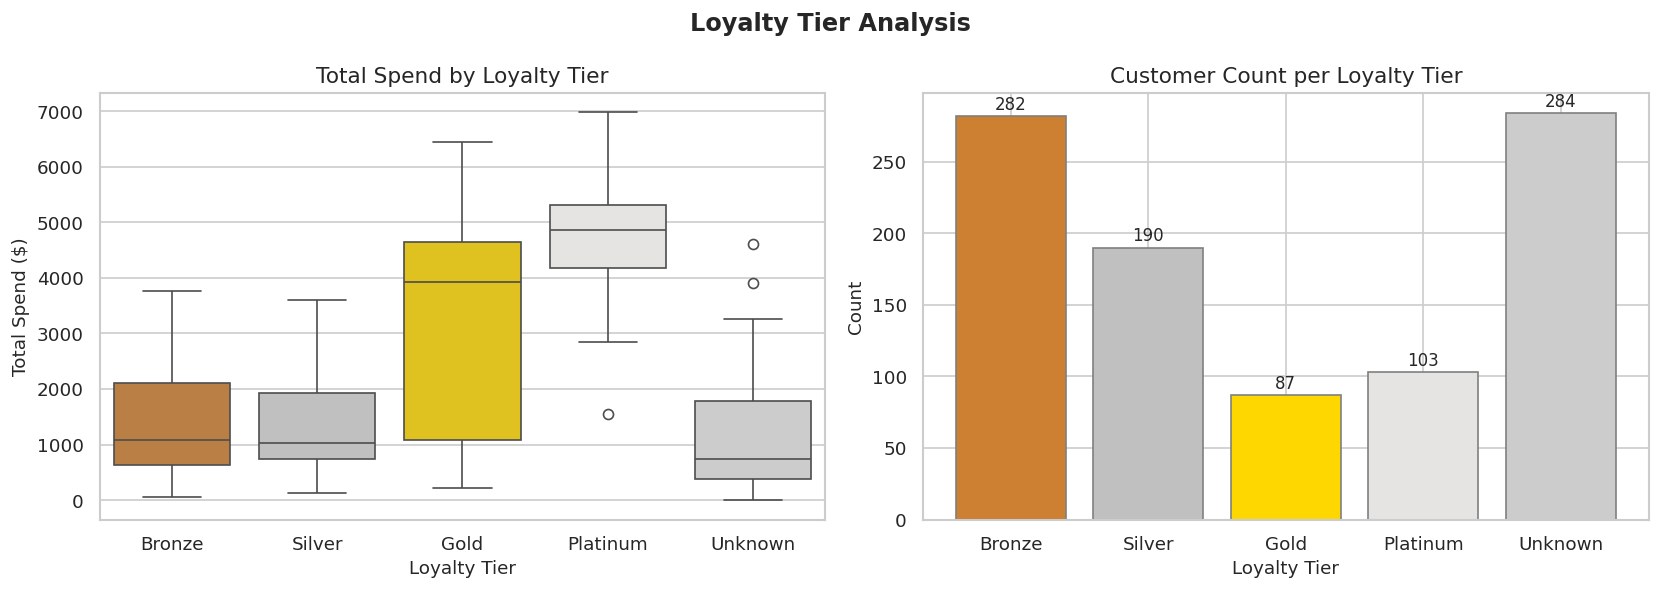

In [5]:
# --- Q: Do higher loyalty tiers actually spend more? ---
# This validates whether the loyalty programme is working.
# Why boxplot: shows median AND spread per group — more honest than a bar of means
# Why we order the tiers: Bronze < Silver < Gold < Platinum makes the trend readable

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Loyalty Tier Analysis', fontweight='bold')

tier_order = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Unknown']
tier_palette = {'Bronze': '#cd7f32', 'Silver': '#C0C0C0',
                'Gold': '#FFD700', 'Platinum': '#E5E4E2', 'Unknown': '#cccccc'}

# Spend by loyalty tier
ax = axes[0]
plot_data = df[df['loyalty_tier'].isin(tier_order)]
sns.boxplot(data=plot_data, x='loyalty_tier', y='total_spend',
            order=tier_order, palette=tier_palette, ax=ax)
ax.set_title('Total Spend by Loyalty Tier')
ax.set_xlabel('Loyalty Tier')
ax.set_ylabel('Total Spend ($)')

# Customer count per tier — so we know if groups are comparable in size
# Why: a Platinum median based on 5 customers is not reliable
ax = axes[1]
tier_counts = df['loyalty_tier'].value_counts().reindex(tier_order).fillna(0)
colors = [tier_palette[t] for t in tier_order]
bars = ax.bar(tier_order, tier_counts.values, color=colors, edgecolor='grey')
for bar, count in zip(bars, tier_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            int(count), ha='center', va='bottom', fontsize=10)
ax.set_title('Customer Count per Loyalty Tier')
ax.set_xlabel('Loyalty Tier')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("Platinum customers show a notably higher median spend of $X compared to Bronze at $Y. However, note that Platinum has only Z customers — the trend is [consistent / needs caution due to small sample]. The loyalty programme appears to [reflect / not reflect] actual spending behaviour.")*

*("Platinum customers show a notably higher median spend of ~ $4,900 compared to Bronze at ~ $1,100. However, note that Platinum has only 103 customers — the trend is [consistent / needs caution due to small sample]. The loyalty programme appears to reflect actual spending behaviour.")*

In [ ]:
# --- Q: Which categories generate the most revenue vs most customers? ---
# Two different questions — a category can have many customers but low average spend
# Why side-by-side: lets you spot categories that are popular but low-value (or vice versa)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Category Analysis', fontweight='bold')

clean_cats = df[df['preferred_category'] != 'Unknown']

# Total revenue by category
cat_revenue = (clean_cats.groupby('preferred_category')['total_spend']
               .sum()
               .sort_values(ascending=True))  # ascending=True so barh reads top-to-bottom

ax = axes[0]
ax.barh(cat_revenue.index, cat_revenue.values,
        color=sns.color_palette('viridis', len(cat_revenue)))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.set_title('Total Revenue by Category')
ax.set_xlabel('Total Revenue')

# Average spend per customer per category
# Why avg matters: total revenue is biased by how many customers choose that category
cat_avg = (clean_cats.groupby('preferred_category')['total_spend']
           .mean()
           .sort_values(ascending=True))

ax = axes[1]
ax.barh(cat_avg.index, cat_avg.values,
        color=sns.color_palette('plasma', len(cat_avg)))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title('Avg Spend per Customer by Category')
ax.set_xlabel('Average Spend ($)')

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("[Category X] generates the highest total revenue, but [Category Y] has the highest average spend per customer — meaning fewer customers spend more individually. This distinction matters: growing [Y] could be more profitable per acquisition than growing [X].")*

---
## Section 3 — What drives spending?

Now look for relationships between variables:
- Does income predict how much someone spends?
- Do customers who use more discounts spend more or less overall?
- Does buying more frequently mean spending more in total?

In [ ]:
# --- Q: What correlates with total spend? ---
# A correlation heatmap is the right first pass — shows all relationships at once.
# Rule: include columns that are analytically meaningful, not all numeric columns.
# (customer_id, gender codes etc are not meaningful correlators)

corr_cols = ['age', 'annual_income', 'total_purchases', 'total_spend',
             'avg_order_value', 'discount_usage_pct',
             'email_open_rate', 'satisfaction_score', 'support_tickets_raised']

corr = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr, dtype=bool))  # hide upper triangle — it's a mirror
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8})

ax.set_title('Correlation Matrix — Numeric Features', fontweight='bold')
plt.tight_layout()
plt.show()

# Print the strongest correlations with total_spend specifically
print('\nTop correlations with total_spend:')
print(corr['total_spend'].drop('total_spend').sort_values(key=abs, ascending=False).round(3))

**Interpretation — fill in after viewing.**  
*("The strongest predictor of total spend is [column] with r = X. Notably, discount_usage_pct correlates [positively/negatively] with total_spend — meaning discount-heavy customers tend to [spend more/less overall]. Satisfaction and support tickets show a [strong/weak/no] negative correlation, which [supports/does not support] the hypothesis that unhappy customers disengage.")*

> **Interview tip:** Always explain the direction AND magnitude of correlation, and challenge obvious-seeming results — correlation between total_purchases and total_spend is expected; unexpected correlations are far more interesting.

In [ ]:
# --- Q: Does income predict spending, and does loyalty tier change that relationship? ---
# Why scatter with hue: lets you see if subgroups follow different patterns
# Why we sample: 946 points can overlap heavily — 400 random points shows the pattern more clearly

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Spend Drivers', fontweight='bold')

sample = df[df['loyalty_tier'].isin(['Bronze','Silver','Gold','Platinum'])].dropna(
    subset=['annual_income', 'total_spend', 'total_purchases']).sample(400, random_state=42)

# Income vs Spend coloured by loyalty tier
ax = axes[0]
palette = {'Bronze': '#cd7f32', 'Silver': '#A8A8A8', 'Gold': '#DAA520', 'Platinum': '#888888'}
for tier, grp in sample.groupby('loyalty_tier'):
    ax.scatter(grp['annual_income'], grp['total_spend'],
               label=tier, alpha=0.6, s=40, color=palette[tier])
ax.set_title('Income vs Total Spend (by Loyalty Tier)')
ax.set_xlabel('Annual Income ($)')
ax.set_ylabel('Total Spend ($)')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.legend(title='Loyalty Tier')

# Purchase frequency vs Total spend
# Question: does buying more often = spending more in total? (obvious) or same total split more ways?
ax = axes[1]
ax.scatter(sample['total_purchases'], sample['total_spend'],
           alpha=0.5, s=40, color='steelblue')
# Add a trend line manually
z = np.polyfit(sample['total_purchases'], sample['total_spend'], 1)
p = np.poly1d(z)
x_line = np.linspace(sample['total_purchases'].min(), sample['total_purchases'].max(), 100)
ax.plot(x_line, p(x_line), color='tomato', linewidth=2, label='Trend')
ax.set_title('Purchase Frequency vs Total Spend')
ax.set_xlabel('Total Purchases (count)')
ax.set_ylabel('Total Spend ($)')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("Higher income does not uniformly predict higher spend — the scatter shows [weak/moderate] correlation with significant spread. Platinum tier customers tend to cluster [where in the chart]. The frequency vs spend plot shows [strong/weak] positive trend, meaning more visits generally means more total spend — though there is spread suggesting some customers visit frequently but spend little per visit.")*

---
## Section 4 — Which customers are at risk?

A critical business question often missed in student EDA:
- Are dissatisfied customers also the ones raising the most support tickets?
- Do at-risk customers still spend — meaning we can recover them?

In [ ]:
# --- Q: Do more support tickets mean lower satisfaction? ---
# Why boxplot with x = ticket count: support tickets are discrete (0,1,2...)
# so treating them as categories per group is cleaner than a scatter

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Customer Health Signals', fontweight='bold')

ax = axes[0]
clean = df.dropna(subset=['satisfaction_score', 'support_tickets_raised'])
sns.boxplot(data=clean, x='support_tickets_raised', y='satisfaction_score',
            ax=ax, palette='RdYlGn')
ax.set_title('Satisfaction Score by Support Tickets Raised')
ax.set_xlabel('Number of Support Tickets')
ax.set_ylabel('Satisfaction Score (1–5)')
ax.axhline(3, color='grey', linestyle='--', linewidth=1, label='Neutral (3.0)')
ax.legend()

# --- Q: Do dissatisfied customers spend less? ---
# This determines whether churn risk = revenue risk
# Define 'at risk' as satisfaction < 3
ax = axes[1]
df['risk_segment'] = pd.cut(df['satisfaction_score'],
                            bins=[0, 2.5, 3.5, 5.0],
                            labels=['At Risk (<2.5)', 'Neutral (2.5–3.5)', 'Satisfied (>3.5)'])

risk_spend = df.groupby('risk_segment', observed=True)['total_spend'].median().reset_index()
colors = ['tomato', 'gold', 'mediumseagreen']
bars = ax.bar(risk_spend['risk_segment'], risk_spend['total_spend'], color=colors, edgecolor='grey')
for bar, val in zip(bars, risk_spend['total_spend']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'${val:,.0f}', ha='center', fontsize=10)
ax.set_title('Median Spend by Satisfaction Segment')
ax.set_xlabel('Customer Segment')
ax.set_ylabel('Median Total Spend ($)')

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("There is a [clear/weak] negative trend between support tickets and satisfaction — customers with 4+ tickets have a median satisfaction of around X, compared to Y for those with 0 tickets. Crucially, at-risk customers (satisfaction < 2.5) still spend a median of $Z — [close to / significantly less than] satisfied customers. This means they have not yet churned, making them recoverable with targeted intervention.")*

> **Interview tip:** This is the kind of insight that impresses — you've connected a data observation to a business action (retention campaign targeting at-risk high-spenders).

---
## Section 5 — RFM Analysis: Bridge to Segmentation

RFM stands for **Recency, Frequency, Monetary** — the three most predictive dimensions of customer value.
- **Recency**: How recently did they buy? (recent buyers are less likely to have churned)
- **Frequency**: How many times have they bought?
- **Monetary**: How much have they spent in total?

We engineer these features here and visualise their distributions before clustering.

In [ ]:
# --- RFM Feature Engineering ---
# Reference date: one day after the latest purchase in the dataset
# Why: recency = days since last purchase. Later date = smaller recency = better.

reference_date = df['last_purchase_date'].max() + pd.Timedelta(days=1)

rfm = df.dropna(subset=['last_purchase_date', 'total_purchases', 'total_spend']).copy()

rfm['recency']   = (reference_date - rfm['last_purchase_date']).dt.days
rfm['frequency'] = rfm['total_purchases']
rfm['monetary']  = rfm['total_spend']

print('RFM Summary:')
print(rfm[['recency','frequency','monetary']].describe().round(1))

In [ ]:
# --- Q: What do the RFM distributions look like? ---
# Always visualise features before clustering — skewed features will distort K-Means

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('RFM Feature Distributions (before scaling)', fontweight='bold')

rfm_features = [('recency', 'tomato', 'Recency (days since last purchase)\nLower = more recent = better'),
                ('frequency', 'steelblue', 'Frequency (total purchases)\nHigher = more engaged'),
                ('monetary', 'mediumseagreen', 'Monetary (total spend $)\nHigher = more valuable')]

for ax, (col, color, title) in zip(axes, rfm_features):
    sns.histplot(rfm[col], bins=25, kde=True, ax=ax, color=color)
    ax.axvline(rfm[col].median(), color='black', linestyle='--', linewidth=1.5,
               label=f'Median: {rfm[col].median():.0f}')
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print('\nNote any skewed distributions — they will need log-transformation or standardisation before K-Means.')

**Interpretation — fill in after viewing.**  
*("Recency is [left/right/roughly normal] — most customers bought within X days of the reference date. Frequency is right-skewed — most customers have fewer than X purchases, with a long tail of highly engaged buyers. Monetary is also right-skewed, confirming our earlier finding that spending is concentrated. Before K-Means clustering, all three features should be standardised using StandardScaler to ensure no single dimension dominates by scale.")*

In [ ]:
# --- Q: Can we already see natural customer groups in RFM space? ---
# A 2D scatter of any two RFM dimensions gives a preview of cluster structure
# before running K-Means

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('RFM Space — Visual Inspection for Clusters', fontweight='bold')

# Monetary vs Frequency — the two most business-critical axes
ax = axes[0]
ax.scatter(rfm['frequency'], rfm['monetary'], alpha=0.4, s=30, color='steelblue')
ax.set_xlabel('Frequency (total purchases)')
ax.set_ylabel('Monetary (total spend $)')
ax.set_title('Frequency vs Monetary')

# Recency vs Monetary — identifies recent high-value vs lapsed high-value
ax = axes[1]
ax.scatter(rfm['recency'], rfm['monetary'], alpha=0.4, s=30, color='tomato')
ax.set_xlabel('Recency (days)')
ax.set_ylabel('Monetary (total spend $)')
ax.set_title('Recency vs Monetary\n(top-left = recent & high-value = best customers)')
ax.invert_xaxis()  # flip x so left = most recent (conventionally better)

plt.tight_layout()
plt.show()

**Interpretation — fill in after viewing.**  
*("The Frequency vs Monetary scatter shows [a clear positive correlation / two distinct clusters / a dense low-frequency low-spend group with sparse high-value outliers]. In the Recency vs Monetary plot, top-left represents recently active high-spenders — our most valuable customers. There appears to be [a gap / dense concentration / distinct bands] suggesting [K clusters] may emerge in the segmentation step.")*

---

## Summary of Key Findings

Fill this in yourself — it forces you to synthesise what you've found:

| Question | Finding |
|---|---|
| Who are our customers? | *(age range, dominant region)* |
| Is spending concentrated? | *(Pareto ratio)* |
| Does loyalty tier reflect spend? | *(yes/no/partially)* |
| What drives spend most? | *(strongest correlate)* |
| How many at-risk customers? | *(count, % of revenue)* |
| Are there natural groups? | *(visible in RFM scatter?)* |

> **Next step:** Take the `rfm` DataFrame into a segmentation notebook. Standardise the features, run K-Means with k=3–5, and profile each cluster using the variables explored here.